In [1]:
from __future__ import print_function

import cv2
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from scipy.spatial import distance

from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark import SparkContext
from pyspark.sql import SQLContext,SparkSession


In [2]:
def find_distance(feature,qfeature):
    try:
        dist = float(distance.euclidean(feature[1],qfeature))
        return (feature[0],dist)
    except:
        return (feature[0],sys.float_info.max)

In [3]:
sc = SparkContext(appName="feature_extractor")
memory = sc._conf.get('spark.driver.memory')
sqlContext = SQLContext(sc)

21/12/30 10:42:13 WARN Utils: Your hostname, vboxubuntu resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
21/12/30 10:42:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/12/30 10:42:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
/home/tejasv55/.local/lib/python3.8/site-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
feature_parquet_path = "alluxio://localhost:19998/ImageNet20000Features"
features = sqlContext.read.parquet(feature_parquet_path)
features_rdd = features.limit(3000).rdd

In [5]:
query_img = cv2.imread("/home/tejasv55/Documents/CBIR-system-using-PySpark-and-Alluxio/Query_Image1.jpg")
# query_img = cv2.resize(query_img, (300,300))
query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2GRAY)
qfeature = hog(query_img)

distances = features_rdd.map(lambda x: find_distance(x,qfeature))
top6 = distances.sortBy(lambda x: x[1]).take(6)

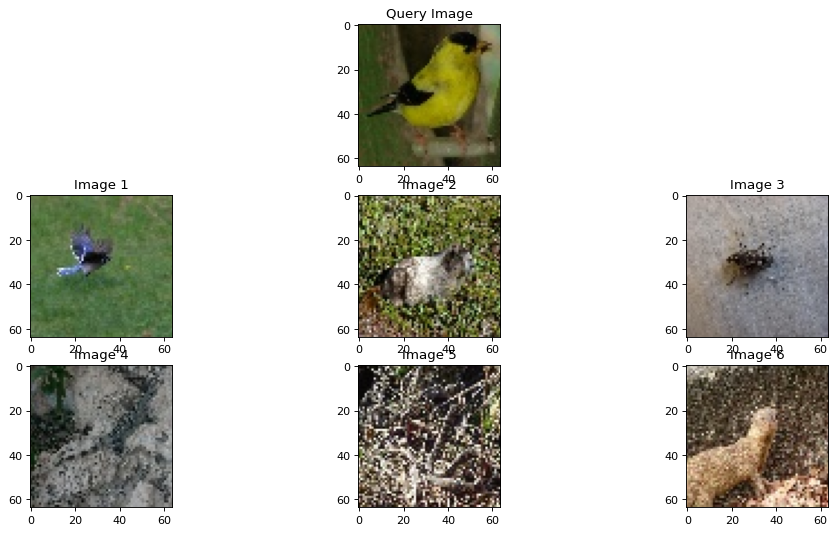

In [9]:
qimg = cv2.imread("/home/tejasv55/Documents/CBIR-system-using-PySpark-and-Alluxio/Query_Image1.jpg")
plt.figure(figsize=(15,8),dpi = 80)
plt.subplot(3,3,2)
plt.title("Query Image")
plt.imshow(cv2.cvtColor(qimg,cv2.COLOR_BGR2RGB))

for (i,x) in enumerate(top6):
    plt.subplot(3,3,4+i)
    plt.title("Image "+str(i+1))
    img = cv2.imread("./ImageNet-20000/"+x[0])
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
